In [1]:
from gurobipy import *

## 本研究

In [2]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
import random
from random import seed
import numpy as np
from scipy.stats import multivariate_normal
def CVaR(ship_num,stack_num,height,n_init,size,size_,beta,mean,cov,OC): 
  O1=[i+1 for i in range(ship_num)]
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n_init)

  a=[]
  dic={}
  for i in OC:
    # print(i)
    if not i in a:
      a.append(i)
  for j in a:
    dic[tuple(j)]=OC.count(j)
  print("Len_dic=",len(dic))
  

  # 期待値と分散共分散行列の準備
  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  global O
  O=O_.tolist()
  m=Model("CVaR")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n_init[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))
  if len(OC)==0:
    for s in S:
      for h in range(2,len(H)+1):
          for i,o in enumerate([O1]):
              for j,p in enumerate(o):
                  m.addConstr(quicksum(x[s,h,k] for k in o[j:])<=quicksum(x[s,h-1,k] for k in o[j:]))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(dic):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=dic[o]*(quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:])))

  for i in range(len(dic)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("実行不可能")
  # m.optimize()

  print("================================================")

  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
    # global x_r
    # x_r=[]
    # for (s,h,i) in x:
    #   if x[s,h,i].X>EPS:
    #     x_r.append(x[s,h,i].X)


    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    global LB
    LB=m.objVal
    # print(result)

    global penalty
    penalty=[]
    for k in O:
      OO=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if OO.index(result[i-1][j])>OO.index(result[i_-1][j]):
                          # print(j+1,height-i+1,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      global zk
      zk=[i for i, x in enumerate(penalty) if x-alpha.X>0]
      # print(a)
    # penalty=np.sort(penalty)
    # print(penalty)

    # penalty=penalty[round(0.75*size):]
    # print(penalty)

def robust(ship_num,stack_num,height,n,Gamma,size_,mean,cov):
  # nと初期配置を変更しなければいけない
  num=sum(n)

  import numpy as np

  O1=[i+1 for i in range(ship_num)]

  Q=[i+1 for i in range(stack_num)]
  L=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  I=[i+1 for i in range(num)]
  f=stack_num*height-len(I)
  a=1
  gamma=[]
  for i in n:
      for j in range(1,i+1):
          gamma.append(a)
      a+=1
  
  m=Model("BI")

  # 変数の定義
  alpha,beta={},{}
  for i in I:
      for q in Q:
          alpha[i,q]=m.addVar(vtype="B")
          beta[i,q]=m.addVar(vtype="B")
  J=[]
  for i in I:
      J.append([])
      for j in I:
          if gamma[i-1]<gamma[j-1]:
              if gamma[j-1]-gamma[i-1]<=Gamma:
                  J[i-1].append(j)

  for q in Q:
      m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

  for i in I:
      m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

  for i in I:
      for j in J[i-1]:
          for q in Q:
              m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

  m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

  if f>=height:
      m.optimize()

  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
      print("====================================================")

      EPS=1.e-6
      a=[]
      for q in Q:
          a.append([])
      for (i,q) in alpha:
          if alpha[i,q].X>EPS:
              a[q-1].append(gamma[i-1])
      
      for (i,q) in beta:
          if beta[i,q].X>EPS:
              a[q-1].append(gamma[i-1])

      for q in Q:
          a[q-1]=sorted(a[q-1],reverse=True)

      global result_r
      result_r=np.zeros((height,stack_num))
      for q in Q:
          for i,r in enumerate(a[q-1]):
              result_r[height-i-1][q-1]=r
          # print(i,r)

      result_r=result_r.astype(int)
      
      print(result_r)
      print("the objective function", m.objVal)

      from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
      import random
      from random import seed
      import numpy as np
      from scipy.stats import multivariate_normal

      np.random.seed()
      data_1 = np.random.multivariate_normal(mean, cov, size=size_)

      O_=np.argsort(data_1)
      O_=O_+np.ones((size_,ship_num)).astype(int)
      OR=O_.tolist()


      global penalty_r
      penalty_r=[]
      for k in OR:
          O=k
          a=0
          for j in range(stack_num):
              for i in range(1,height):
                  for i_ in range(i+1,height+1):
                      if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                          if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                              a+=1
                              # if Gamma ==2:
                                # print(j+1,height-i+1,O)
                              # print("penalty!")
                              # print(i,i_,j+1,O)
                              break
          penalty_r.append(a)
      
      penalty_r=np.sort(penalty_r)
      penalty_r=penalty_r[round(0.75*size_):]
      # print(penalty_r)

      # import matplotlib.pyplot as plt
      # plt.boxplot(penalty_r)

In [5]:
size=1000
size_=10000
beta=0.75
inst=[4,4,[3,3,1,1,2,2]]
pcvar=[]
import numpy as np
# mean=np.arange(1,ship_num+1)
mean=np.array([1,1.5,4,4.5,5,5.6])
covl=[1,1,1.5,1,1,1.5]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[i]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0
OC=[]
EPS=0.01
a=0
UB=1000
LB=0
UB_k=[]
aaa=[]
while UB-LB>=EPS:
    print("UB=",UB)
    print("LB=",LB)
    print("UB-LB=",UB-LB)
    print("LEN=",len(OC))
    CVaR(len(inst[2]),inst[0],inst[1],inst[2],size,size_,beta,mean,cov,OC)
    n=0
    tau=int(beta*size)
    N_sigma=np.sort(penalty)
    alpha_=N_sigma[tau-1]

    UB=((tau/size-beta)*alpha_+sum(N_sigma[tau:]))/((1-beta)*size)
    UB_k.append(UB)
    UB=min(UB_k)
    for b in zk:
        # if not b in aaa:
        #     aaa.append(b)
        OC.append(O[b])
    a+=1
    # print(OC)
    print(result)
print("finish!!")


UB= 1000
LB= 0
UB-LB= 1000
LEN= 0
Len_dic= 0
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 106 rows, 13097 columns and 840 nonzeros
Model fingerprint: 0x540b247f
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
VaR= 0.0
the objective function 0.0
[[0 0 0 1]
 [3 1 0 2]
 [5 1 2 2]
 [5 6 4 6]]
UB= 1.496
LB= 0.0
UB-LB= 1.496
LEN= 553
Len_dic= 68
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count:

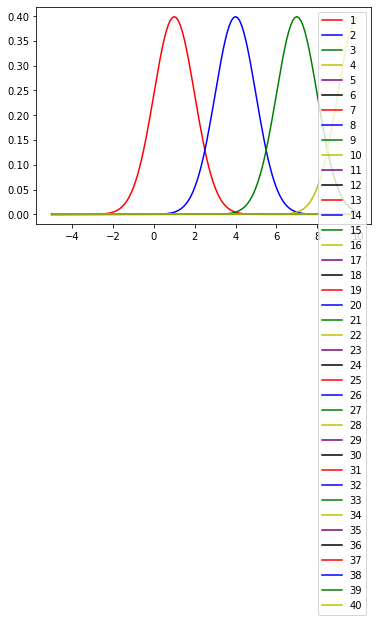

In [13]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline

color=["r","b","g","y","purple","black"]
mean=np.arange(1,3*len(inst[2])+1,3)
covl=[1 for i in range(len(mean))]
y=covl
X=np.arange(-5,10,0.1)
for i,j in enumerate(mean):
  Y=norm.pdf(X,j,y[i])
  plt.plot(X,Y,color=color[i%6],label=i+1)
# plt.title("scale="+str(y[0]))
plt.legend()
plt.show()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 92 rows, 96 columns and 420 nonzeros
Model fingerprint: 0x4674e4c6
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 0 rows and 8 columns
Presolve time: 0.00s
Presolved: 92 rows, 88 columns, 388 nonzeros
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

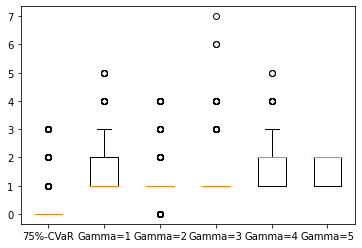

In [6]:
data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,len(inst[2]))).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
penalty_cvar=penalty_cvar[round(0.75*size_):]
pcvar=[]
pcvar+=list(penalty_cvar)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
#   print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()
# plt.hist(penalty_cvar,bins=50)
# plt.show()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 92 rows, 96 columns and 420 nonzeros
Model fingerprint: 0x4674e4c6
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 0 rows and 8 columns
Presolve time: 0.00s
Presolved: 92 rows, 88 columns, 388 nonzeros
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

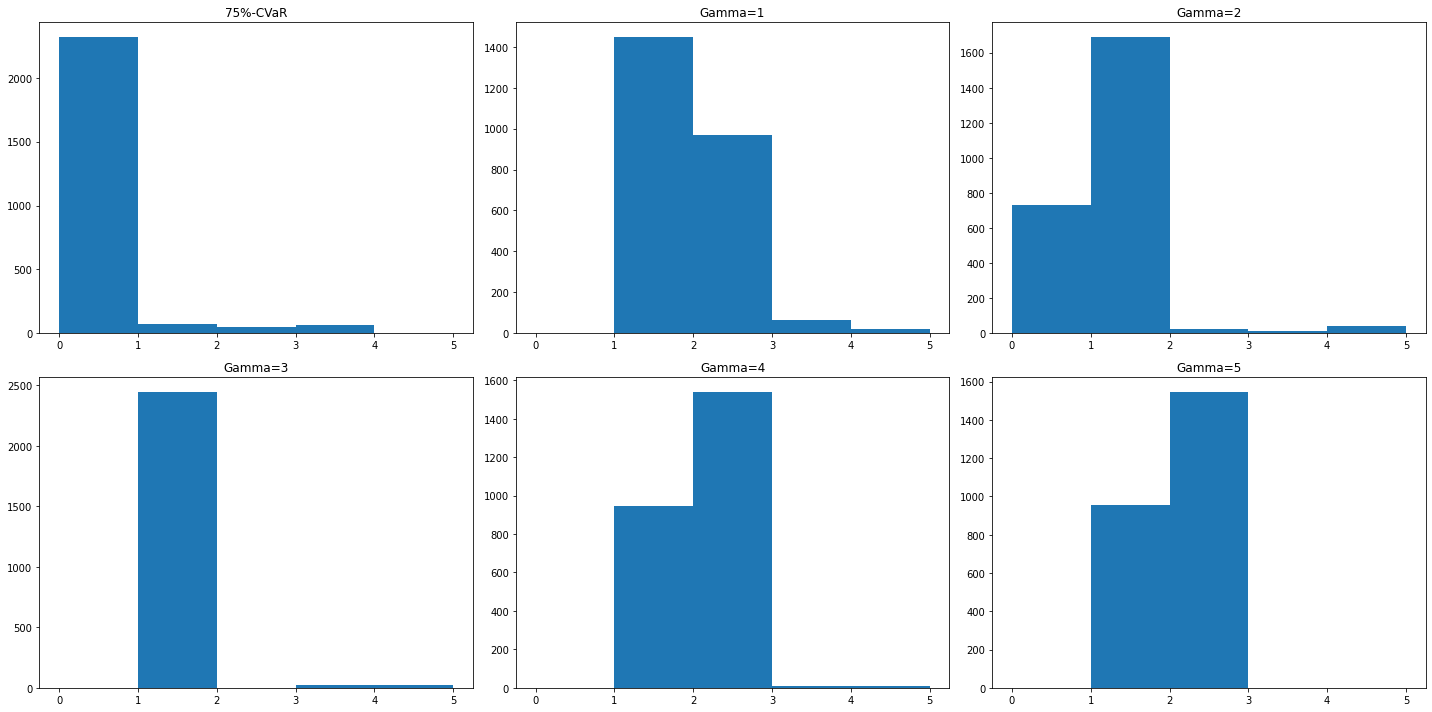

len= 2500


In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
  # print(prob)
  # data+=(tuple(prob),)
  # l.append("Gamma="+str(g))
  # print("data=",data)
# plt.boxplot(data,labels=l)
# plt.show()

  ax[int(g/3)][g%3].hist(prob,bins=5,range=(0,5))
  ax[int(g/3)][g%3].set_title("Gamma="+str(g))
ax[0][0].hist(penalty_cvar,bins=5,range=(0,5))
ax[0][0].set_title("75%-CVaR")
plt.show()
print("len=",len(prob))

In [6]:
print(result)

[[1 2 0 0]
 [1 2 2 0]
 [1 6 5 0]
 [4 6 5 3]]


## 大きい問題サイズ

In [14]:
size=1000
size_=10000
beta=0.75
inst=[7,7,[1 for i in range(40)]]
pcvar=[]
import numpy as np
mean=np.arange(1,3*len(inst[2])+1,3)
covl=[1 for i in range(len(mean))]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[i]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0
OC=[]
EPS=0.01
a=0
UB=1000
LB=0
UB_k=[]
aaa=[]
while UB-LB>=EPS:
    print("UB=",UB)
    print("LB=",LB)
    print("UB-LB=",UB-LB)
    print("LEN=",len(OC))
    CVaR(len(inst[2]),inst[0],inst[1],inst[2],size,size_,beta,mean,cov,OC)
    n=0
    tau=int(beta*size)
    N_sigma=np.sort(penalty)
    alpha_=N_sigma[tau-1]

    UB=((tau/size-beta)*alpha_+sum(N_sigma[tau:]))/((1-beta)*size)
    UB_k.append(UB)
    UB=min(UB_k)
    for b in zk:
        # if not b in aaa:
        #     aaa.append(b)
        OC.append(O[b])
    a+=1
    # print(OC)
    print(result)
print("finish!!")


UB= 1000
LB= 0
UB-LB= 1000
LEN= 0
Len_dic= 0
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1811 rows, 44961 columns and 76160 nonzeros
Model fingerprint: 0x260509aa
Variable types: 43001 continuous, 1960 integer (1960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 188 rows and 43112 columns
Presolve time: 1.37s
Presolved: 1623 rows, 1849 columns, 60315 nonzeros
Variable types: 0 continuous, 1849 integer (1849 binary)

Root relaxation: interrupted, 0 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       0.0000000    0.00000  0.00%     -    1s

Explored 1 nodes (0 simplex it